<a href="https://colab.research.google.com/github/RezaRejo/Final-Project-Data-Science/blob/main/Feature_Engineering_Modeling_Machine_Learning_%2B_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Preparation

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt

##Access to Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Read Data

In [ ]:
file_path = '/content/drive/MyDrive/Dibimbing DS33B+/FINAL PROJECT DS DA/PROJECT/Final Project Data Science/gym_membership_final.csv'
df = pd.read_csv(file_path)
df.head()

,id,gender,birthday,age,abonoment_type,visit_per_week,days_per_week,attend_group_lesson,avg_time_check_in,avg_time_check_out,...,uses_sauna,last_visit_date,recency,abonoment_value,personal_training_val,drink_abo_val,sauna_val,monetary,age_category,number_of_members
0,1,Female,1997-04-18,27,Premium,4,"Mon, Sat, Tue, Wed",True,19:31:00,21:27:00,...,True,2025-05-02,51,2,0,0,1,250,Young Adult,493
1,2,Female,1977-09-18,47,Standard,3,"Mon, Sat, Wed",False,19:31:00,20:19:00,...,False,2025-06-08,14,1,1,0,0,180,Mature,507
2,3,Male,1983-03-30,41,Premium,1,Sat,True,08:29:00,10:32:00,...,False,2025-04-12,71,2,1,1,0,280,Mature,493
3,4,Male,1980-04-12,44,Premium,3,"Sat, Tue, Wed",False,09:54:00,11:33:00,...,True,2025-04-23,60,2,1,1,1,310,Mature,493
4,5,Male,1980-09-10,44,Standard,2,"Thu, Wed",True,08:29:00,09:19:00,...,False,2025-06-02,20,1,1,0,0,170,Mature,507


#Feature Engineering

In [ ]:
# Copy dataframe agar aman
df_feat = df.copy()

##Demographics

In [ ]:
# Gender encoding
df_feat["gender_encoded"] = df_feat["gender"].map({"Male": 1, "Female": 0})

# Tahun lahir
df_feat["birth_year"] = pd.to_datetime(df_feat["birthday"]).dt.year

##Gym Behavior

In [ ]:
# Jumlah hari aktif per minggu
df_feat["active_days_count"] = df_feat["days_per_week"].apply(lambda x: len(x.split(",")))

# Konsistensi kunjungan (kunjungan per hari aktif)
df_feat["visit_consistency"] = df_feat["visit_per_week"] / df_feat["active_days_count"]

# Kategorisasi jam check-in (morning <12, afternoon 12-18, evening >18)
df_feat["checkin_period"] = pd.to_datetime(df_feat["avg_time_check_in"], format="%H:%M:%S").dt.hour
df_feat["checkin_period"] = pd.cut(
    df_feat["checkin_period"],
    bins=[0,12,18,24],
    labels=["Morning","Afternoon","Evening"],
    right=False
)

In [ ]:
# =============================
# FEATURE ENGINEERING
# =============================

import numpy as np

# 1. Churn Flag (target variable)
# Anggota dianggap churn jika recency >= 60 hari
df["churn_flag"] = df["recency"].apply(lambda x: 1 if x >= 60 else 0)

# 2. Loyalty Score (gabungan frekuensi kunjungan & recency)
df["loyalty_score"] = df["visit_per_week"] * (1 / (df["recency"] + 1))

# 3. Average Spend per Visit
df["avg_spend_per_visit"] = df["monetary"] / (df["visit_per_week"] * 4 + 1)

# 4. Active Flag (masih aktif jika recency < 30 hari)
df["active_flag"] = df["recency"].apply(lambda x: 1 if x < 30 else 0)

# 5. Engagement Level (kategori berdasarkan frekuensi kunjungan per minggu)
def engagement(x):
    if x >= 4:
        return "High"
    elif x >= 2:
        return "Medium"
    else:
        return "Low"

df["engagement_level"] = df["visit_per_week"].apply(engagement)

# 6. Customer Lifetime Value (CLV Estimate)
df["clv_estimate"] = df["monetary"] * df["visit_per_week"]

# 7. Extra Services (jumlah layanan tambahan yang digunakan)
df["extra_services"] = df[["drink_abo_val", "personal_training_val", "sauna_val"]].sum(axis=1)

# =============================
# CEK HASIL
# =============================
print(df[[
    "id", "recency", "visit_per_week", "monetary",
    "churn_flag", "loyalty_score", "avg_spend_per_visit",
    "active_flag", "engagement_level", "clv_estimate", "extra_services"
]].head())

   id   recency  visit_per_week  monetary  churn_flag  loyalty_score  \
0   1  0.293301        1.061773  0.554427           0       0.820979   
1   2 -1.110781        0.256179 -0.617016           0      -2.312479   
2   3  1.052265       -1.355009  1.056474           0      -0.660250   
3   4  0.634835        0.256179  1.558521           0       0.156700   
4   5 -0.883092       -0.549415 -0.784365           0      -4.699550   

   avg_spend_per_visit  active_flag engagement_level  clv_estimate  \
0             0.105664            1              Low      0.588676   
1            -0.304742            1              Low     -0.158066   
2            -0.239019            1              Low     -1.431532   
3             0.769748            1              Low      0.399260   
4             0.654914            1              Low      0.430942   

   extra_services  
0               1  
1               1  
2               2  
3               3  
4               1  


##Additional Services

In [ ]:
# Total fasilitas tambahan
df_feat["extra_services_count"] = df_feat[["attend_group_lesson","drink_abo","personal_training","uses_sauna"]].sum(axis=1)

# Fasilitas premium score
df_feat["premium_score"] = df_feat["personal_training_val"] + df_feat["drink_abo_val"] + df_feat["sauna_val"]

##Loyalty and Retention

In [ ]:
# Recency bucket
df_feat["recency_bucket"] = pd.cut(
    df_feat["recency"],
    bins=[-1,30,60,999],
    labels=["Active","At Risk","Churn"]
)

# Monetary per visit (dibagi total kunjungan mingguan * jumlah member)
df_feat["monetary_per_visit"] = df_feat["monetary"] / (df_feat["visit_per_week"] * df_feat["number_of_members"])
df_feat["monetary_per_visit"].replace([np.inf, -np.inf], np.nan, inplace=True)

# Value/Cost ratio
df_feat["value_cost_ratio"] = df_feat["monetary"] / (df_feat["abonoment_value"] + 1)  # +1 biar ga div 0

/tmp/ipython-input-2964394601.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_feat["monetary_per_visit"].replace([np.inf, -np.inf], np.nan, inplace=True)


##Output

In [ ]:
print(df_feat.head(10))

   id  gender    birthday  age abonoment_type  visit_per_week  \
0   1  Female  1997-04-18   27        Premium               4   
1   2  Female  1977-09-18   47       Standard               3   
2   3    Male  1983-03-30   41        Premium               1   
3   4    Male  1980-04-12   44        Premium               3   
4   5    Male  1980-09-10   44       Standard               2   
5   6  Female  2009-06-29   15       Standard               1   
6   7    Male  1994-08-07   30        Premium               3   
7   8    Male  2003-11-13   20       Standard               2   
8   9    Male  1978-07-28   46        Premium               3   
9  10  Female  2000-05-06   24        Premium               1   

        days_per_week  attend_group_lesson avg_time_check_in  \
0  Mon, Sat, Tue, Wed                 True          19:31:00   
1       Mon, Sat, Wed                False          19:31:00   
2                 Sat                 True          08:29:00   
3       Sat, Tue, Wed       

#EDA FE

##Recency Bucket

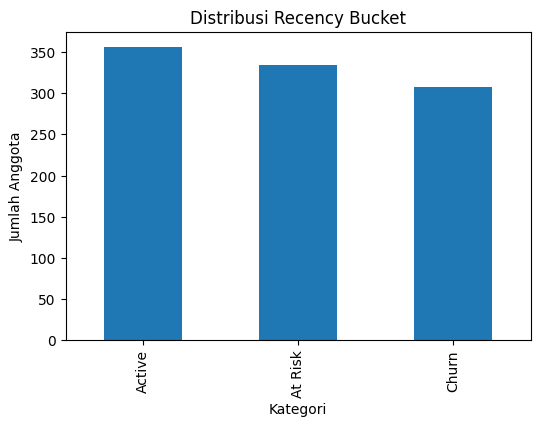

In [ ]:
# --- Distribusi Recency Bucket ---
plt.figure(figsize=(6,4))
df_feat["recency_bucket"].value_counts().plot(kind="bar")
plt.title("Distribusi Recency Bucket")
plt.xlabel("Kategori")
plt.ylabel("Jumlah Anggota")
plt.show()

##Check-in Period

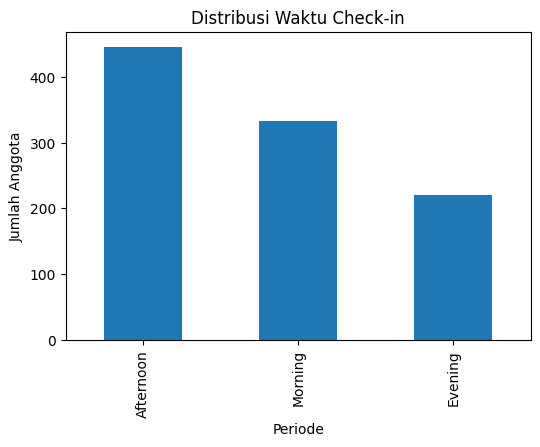

In [ ]:
# --- Distribusi Check-in Period ---
plt.figure(figsize=(6,4))
df_feat["checkin_period"].value_counts().plot(kind="bar")
plt.title("Distribusi Waktu Check-in")
plt.xlabel("Periode")
plt.ylabel("Jumlah Anggota")
plt.show()

##Extra Services Count

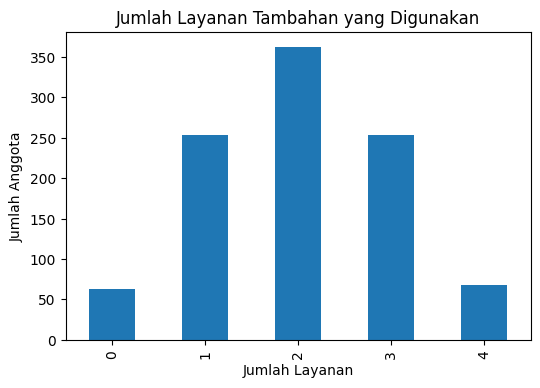

In [ ]:
# --- Extra Services Count ---
plt.figure(figsize=(6,4))
df_feat["extra_services_count"].value_counts().sort_index().plot(kind="bar")
plt.title("Jumlah Layanan Tambahan yang Digunakan")
plt.xlabel("Jumlah Layanan")
plt.ylabel("Jumlah Anggota")
plt.show()

##Premium Score

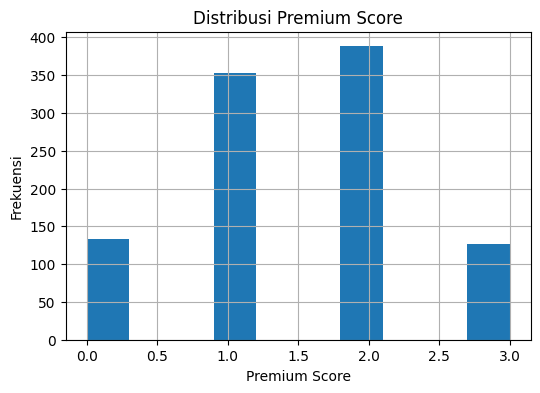

In [ ]:
# --- Premium Score ---
plt.figure(figsize=(6,4))
df_feat["premium_score"].hist(bins=10)
plt.title("Distribusi Premium Score")
plt.xlabel("Premium Score")
plt.ylabel("Frekuensi")
plt.show()

##Monetary

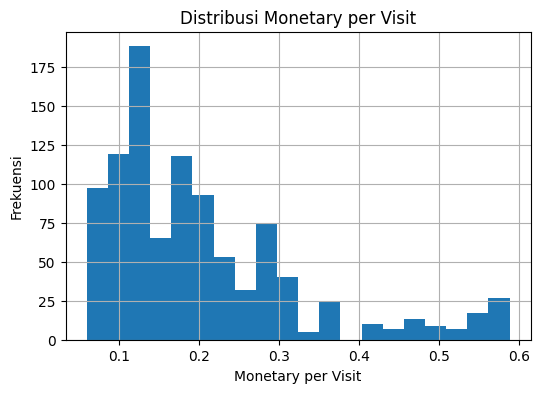

In [ ]:
# --- Monetary per Visit ---
plt.figure(figsize=(6,4))
df_feat["monetary_per_visit"].hist(bins=20)
plt.title("Distribusi Monetary per Visit")
plt.xlabel("Monetary per Visit")
plt.ylabel("Frekuensi")
plt.show()

##Value Cost Ratio

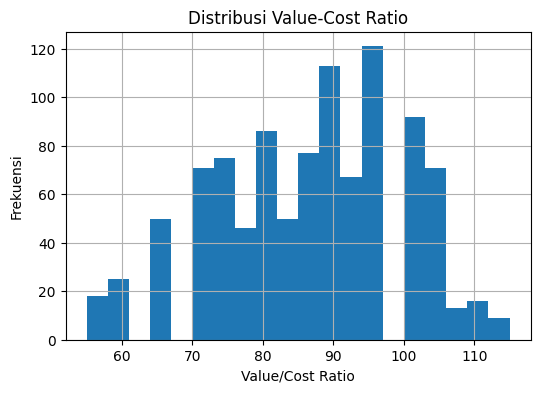

In [ ]:
# --- Value Cost Ratio ---
plt.figure(figsize=(6,4))
df_feat["value_cost_ratio"].hist(bins=20)
plt.title("Distribusi Value-Cost Ratio")
plt.xlabel("Value/Cost Ratio")
plt.ylabel("Frekuensi")
plt.show()

#Machine Learning

In [ ]:
# Tambahkan target churn (1 jika recency > 60 hari, else 0)
df_feat["churn"] = df_feat["recency"].apply(lambda x: 1 if x > 60 else 0)

##Select features

In [ ]:
features = [
    "age","gender_encoded","visit_per_week","active_days_count",
    "visit_consistency","avg_time_in_gym","abonoment_value",
    "premium_score","monetary"
]
X = df_feat[features]
y = df_feat["churn"]
print(X.head())

   age  gender_encoded  visit_per_week  active_days_count  visit_consistency  \
0   27               0               4                  4                1.0   
1   47               0               3                  3                1.0   
2   41               1               1                  1                1.0   
3   44               1               3                  3                1.0   
4   44               1               2                  2                1.0   

   avg_time_in_gym  abonoment_value  premium_score  monetary  
0              116                2              1       250  
1               48                1              1       180  
2              123                2              2       280  
3               99                2              3       310  
4               50                1              1       170  


##Train-Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Jumlah data training:", X_train.shape[0])
print("Jumlah data testing :", X_test.shape[0])
print("Total data          :", X.shape[0])

Jumlah data training: 800
Jumlah data testing : 200
Total data          : 1000


##Logistic Regression with scaling

In [ ]:
log_reg = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000))
])
log_reg.fit(X_train, y_train)
y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:,1]

##Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:,1]

#Evaluation

##Logistic Regression

In [ ]:
print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_lr))
print(classification_report(y_test, y_pred_lr))

=== Logistic Regression ===
Accuracy: 0.69
ROC-AUC: 0.4922861150070126
              precision    recall  f1-score   support

           0       0.69      1.00      0.82       138
           1       0.00      0.00      0.00        62

    accuracy                           0.69       200
   macro avg       0.34      0.50      0.41       200
weighted avg       0.48      0.69      0.56       200



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


##Random Forest

In [ ]:
print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))
print(classification_report(y_test, y_pred_rf))


=== Random Forest ===
Accuracy: 0.635
ROC-AUC: 0.5459911173445535
              precision    recall  f1-score   support

           0       0.70      0.83      0.76       138
           1       0.34      0.19      0.25        62

    accuracy                           0.64       200
   macro avg       0.52      0.51      0.50       200
weighted avg       0.59      0.64      0.60       200



##Confusion Matrix (Random Forest)

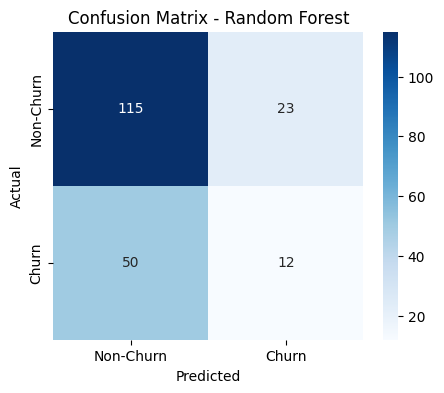

In [ ]:
cm = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Churn","Churn"], yticklabels=["Non-Churn","Churn"])
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

##Feature Importance (Random Forest)

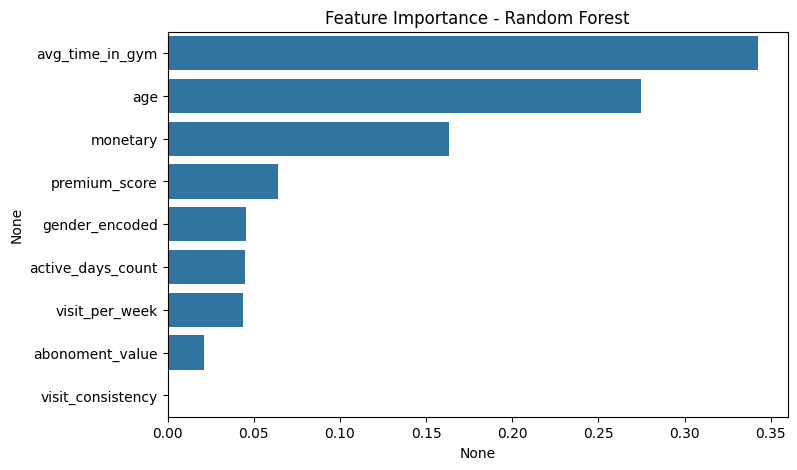

In [ ]:
feat_importances = pd.Series(rf.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=feat_importances, y=feat_importances.index)
plt.title("Feature Importance - Random Forest")
plt.show()

##Missing

In [ ]:
#missing value
df_feat.isna().sum()

,0
id,0
gender,0
birthday,0
age,0
abonoment_type,0
visit_per_week,0
days_per_week,0
attend_group_lesson,0
avg_time_check_in,0
avg_time_check_out,0
